### Description: Mean Reversion Trading Strategy

In [3]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [6]:
#Load the data
end = dt.datetime.now()
start = end - dt.timedelta(days=365*5)
df = yf.download('SLV', start, end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-28,13.45,13.46,13.39,13.46,13.46,9200700
2019-05-29,13.55,13.57,13.49,13.52,13.52,5309000
2019-05-30,13.55,13.66,13.53,13.60,13.60,4695300
2019-05-31,13.61,13.76,13.60,13.65,13.65,8236000
2019-06-03,13.77,13.90,13.75,13.87,13.87,13206800


In [7]:
# Create a function to calculate the simple moving average
def SMA(data, period=30, column = 'Close'):
    return data[column].rolling(window=period).mean()

In [8]:
# Build and show the dataset
df['SMA'] = SMA(df, 21)
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1 + df['Simple_Returns'])
df['Ratios'] = df['Close'] / df['SMA']
# Show the data
df

,Open,High,Low,Close,Adj Close,Volume,SMA,Simple_Returns,Log_Returns,Ratios
Date,,,,,,,,,,
2019-05-28,13.450000,13.460000,13.390000,13.460000,13.460000,9200700,NaN,NaN,NaN,NaN
2019-05-29,13.550000,13.570000,13.490000,13.520000,13.520000,5309000,NaN,0.004458,0.004448,NaN
2019-05-30,13.550000,13.660000,13.530000,13.600000,13.600000,4695300,NaN,0.005917,0.005900,NaN
2019-05-31,13.610000,13.760000,13.600000,13.650000,13.650000,8236000,NaN,0.003676,0.003670,NaN
2019-06-03,13.770000,13.900000,13.750000,13.870000,13.870000,13206800,NaN,0.016117,0.015989,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-05-17,27.860001,28.840000,27.549999,28.790001,28.790001,52708100,25.436667,0.063932,0.061972,1.131831
2024-05-20,28.930000,29.559999,28.410000,28.980000,28.980000,58184700,25.569048,0.006599,0.006578,1.133402
2024-05-21,29.100000,29.510000,28.820000,29.270000,29.270000,30700300,25.775714,0.010007,0.009957,1.135565


In [9]:
# Get some statistics on the Ratio column
df['Ratios'].describe()

count    1238.000000
mean        1.005842
std         0.051117
min         0.723826
25%         0.976489
50%         1.003398
75%         1.032286
max         1.289209
Name: Ratios, dtype: float64

In [10]:
#Get and show the percentile values
percentiles = [15, 20, 50, 80, 85]

# Remove any NA values in the Ratios column and store the result in a new variable called ratios
ratios = df['Ratios'].dropna()

# Get the values of the percentiles
percentile_values = np.percentile(ratios, percentiles)

# Show the values of the percentiles
percentile_values

array([0.95928573, 0.96899813, 1.00339834, 1.04197262, 1.05252379])

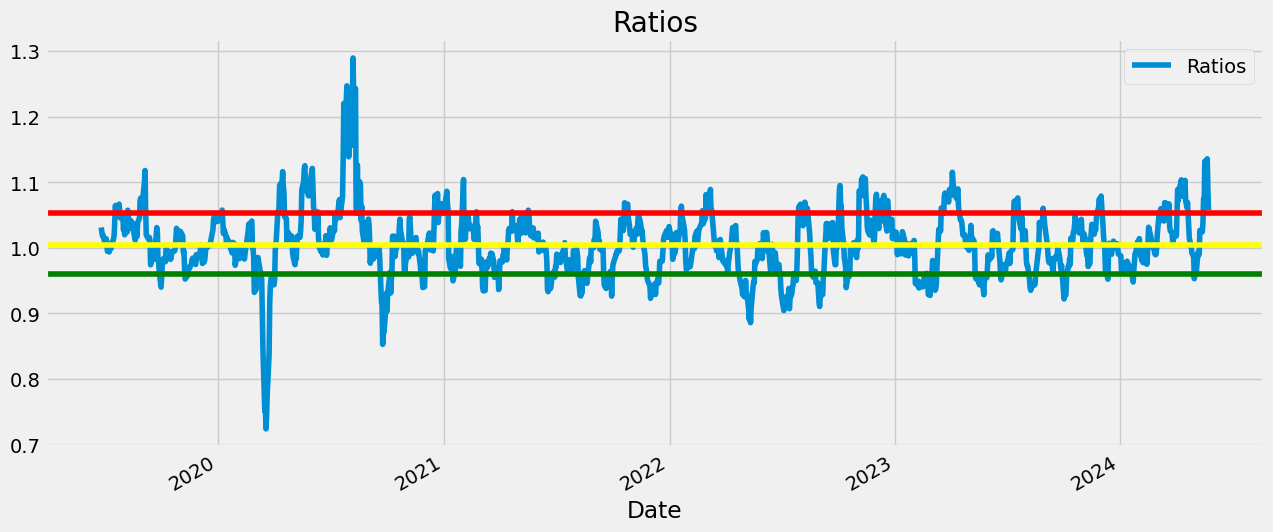

In [13]:
#Plot the ratios 
plt.figure(figsize=(14,6))
plt.title('Ratios')
df['Ratios'].dropna().plot(legend=True)
plt.axhline(percentile_values[0], c='green', label='15th Percentile')
plt.axhline(percentile_values[2], c='yellow', label='50th Percentile')
plt.axhline(percentile_values[-1], c='red', label='85th Percentile')
plt.show()

In [15]:
# Create buy and sell signals for the strategy
sell = percentile_values[-1] # 85th percentile threshold where we want to sell
buy = percentile_values[0] # the 15th percentile threshold where we want to buy
# Put -1 where the ratio is greater than the percentile to sell and nan otherwise
df['Positions'] = np.where(df.Ratios > sell, -1, np.nan)
# Put 1 where the ratio is less than the percentile to buy and put the current value otherwise
df['Positions'] = np.where(df.Ratios < buy, 1, df['Positions'])
# Use ffill to fill the missing values in the dataframe. Ffill stands for forward fill
df['Positions'] = df['Positions'].ffill()

# Get the buy and sell signals
df['Buy'] = np.where(df.Positions == 1, df['Close'], np.nan)
df['Sell'] = np.where(df.Positions == -1, df['Close'], np.nan)

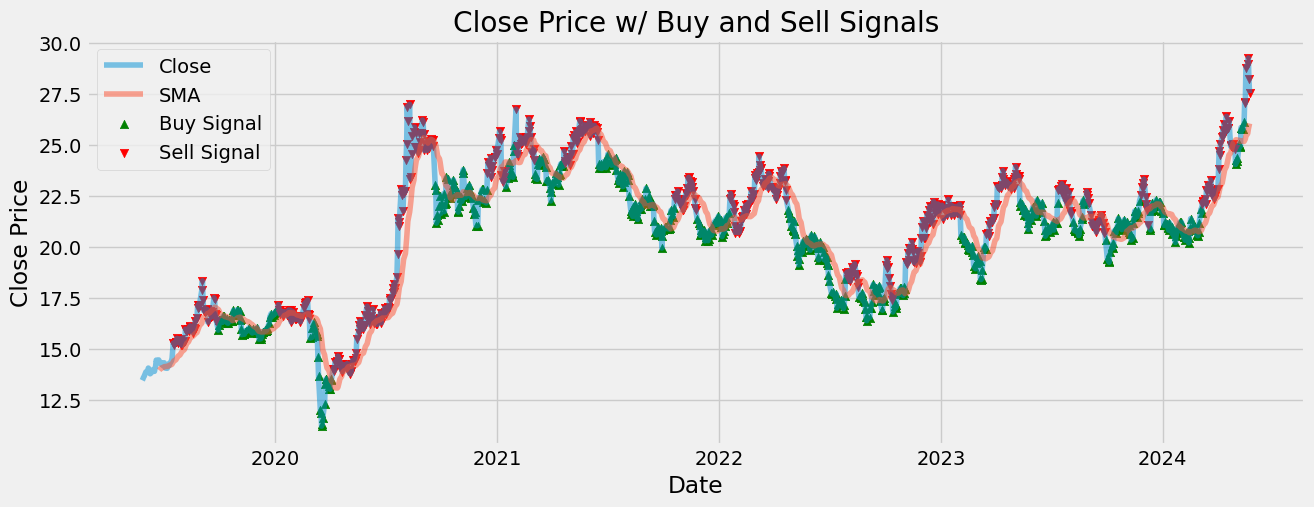

In [17]:
# Visualize the buy and sell signals along with the close price 
plt.figure(figsize=(14,5))
plt.title('Close Price w/ Buy and Sell Signals')
plt.plot(df['Close'], alpha=0.5, label='Close')
plt.plot(df['SMA'], alpha=0.5, label='SMA')
plt.scatter(df.index, df['Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(df.index, df['Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [18]:
# Calculate the returns for the Mean Reversion Strategy
df['Strategy_Returns'] = df.Positions.shift(1) * df.Log_Returns
df['Strategy_Returns']

Date
2019-05-28         NaN
2019-05-29         NaN
2019-05-30         NaN
2019-05-31         NaN
2019-06-03         NaN
                ...   
2024-05-17   -0.061972
2024-05-20   -0.006578
2024-05-21   -0.009957
2024-05-22    0.036532
2024-05-23    0.024028
Name: Strategy_Returns, Length: 1258, dtype: float64

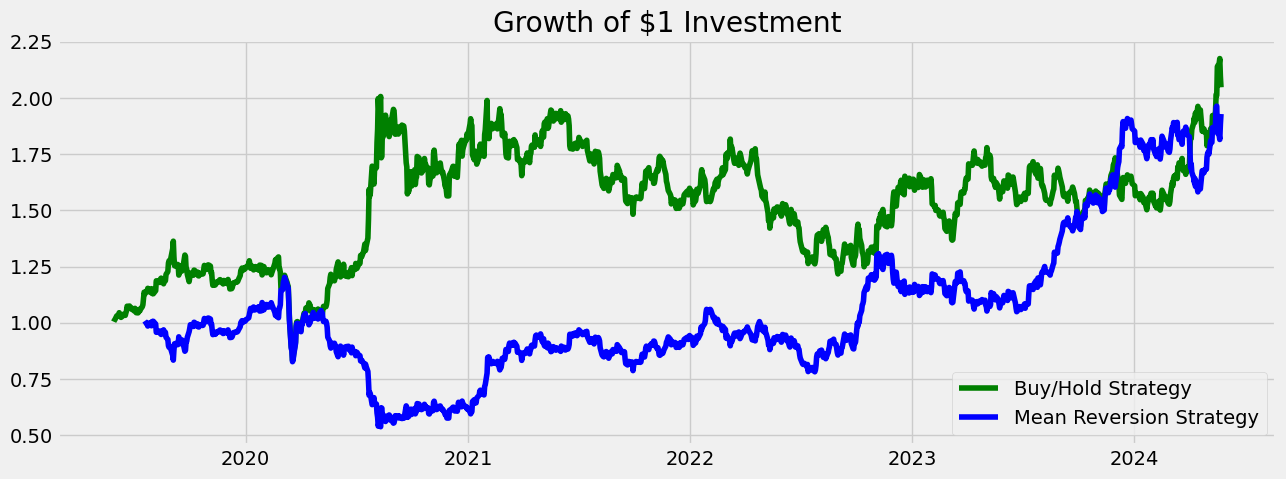

In [19]:
# Plot the cumulative log returns and the cumulative Mean Reversion Strategy
plt.figure(figsize=(14,5))
plt.title('Growth of $1 Investment')
plt.plot(np.exp(df['Log_Returns'].dropna()).cumprod(), c = "green", label='Buy/Hold Strategy')
plt.plot(np.exp(df['Strategy_Returns'].dropna()).cumprod(), c = "blue", label='Mean Reversion Strategy')
plt.legend()
plt.show()

In [20]:
# Print the returns for both strategies
print('Buy and Hold Strategy Returns:', np.exp(df['Log_Returns'].dropna()).cumprod()[-1] - 1)

Buy and Hold Strategy Returns: 1.0468052866999367


/tmp/ipykernel_7356/972032664.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Buy and Hold Strategy Returns:', np.exp(df['Log_Returns'].dropna()).cumprod()[-1] - 1)


In [21]:
print('Mean Reversion Strategy Returns:', np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1] - 1)

Mean Reversion Strategy Returns: 0.9279772531818531


/tmp/ipykernel_7356/291311729.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Mean Reversion Strategy Returns:', np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1] - 1)
